In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import datacube

import matplotlib.pyplot as plt
import matplotlib.cm as color_maps  
from matplotlib.pyplot import figure, cm

import json
import time
import sys
import os

import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge

#from rasterio.plot import show
#import rioxarray as rio

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import ogr, gdal

from datetime import datetime
#from time import time

import skimage
from skimage import exposure
from skimage import morphology
from skimage.morphology import disk
from skimage.morphology import rectangle
from skimage.filters import rank

import glob
import fiona
import subprocess

from rmmeh.vanilla import rmmeh

In [2]:
"""Reads ProbaV TIFF files into a dataarray."""
import re
from pathlib import Path
# 3rd party modules
import pandas as pd
import xarray as xr
import rioxarray as rxr


_default_prefix = '/srv/data-dir/satellite/downloaded/probav/LAI_probav'
_default_regex = 'PROBAV_(?P<band>.*?)_(?P<date>....-..-..).TIF'
_default_chunks = {'x':1024,'y':1024}


def probav_df(
    prefix = _default_prefix,
    regex = _default_regex,
 ):
    """List all ProbaV TIFF files into a dataframe for easy filtering (by date)."""
    regex = re.compile(regex)
    prefix = Path(prefix)
    #
    df = pd.Series(
        (path for path in prefix.glob('*')),
        name = 'path',
    ).to_frame()
    df['name'] = df['path'].apply(lambda x: x.name)
    df = pd.concat((df, df['name'].str.extract(regex)), axis = 1).dropna()
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date').sort_index()


def load_from_df(df, check = False):
    da = xr.concat(
        (rxr.open_rasterio(x, chunks = _default_chunks) for x in df['path']),
        'time',
        join = 'exact' if check else 'outer',
    ).squeeze(drop = True).assign_coords(time = list(df.index)).rename(x = 'longitude', y = 'latitude')
    da.name = ','.join(df['band'].unique())
    return da


def load(
    prefix = _default_prefix,
    regex = _default_regex,
    check = False,
    date_slice = slice(None,None),
):
    return load_from_df(
        probav_df(prefix, regex)[date_slice],
        check,
    )




In [3]:

print('=== Unit tester of ProbaV TIFF files adhoc reader.')
print('=== searching for file paths into dataframe "df":')
df = probav_df()
print(df)


=== Unit tester of ProbaV TIFF files adhoc reader.
=== searching for file paths into dataframe "df":
                                                         path  \
date                                                            
2015-01-10  /srv/data-dir/satellite/downloaded/probav/LAI_...   
2015-01-20  /srv/data-dir/satellite/downloaded/probav/LAI_...   
2015-01-31  /srv/data-dir/satellite/downloaded/probav/LAI_...   
2015-02-10  /srv/data-dir/satellite/downloaded/probav/LAI_...   
2015-02-20  /srv/data-dir/satellite/downloaded/probav/LAI_...   
...                                                       ...   
2021-08-31  /srv/data-dir/satellite/downloaded/probav/LAI_...   
2021-09-10  /srv/data-dir/satellite/downloaded/probav/LAI_...   
2021-09-20  /srv/data-dir/satellite/downloaded/probav/LAI_...   
2021-09-30  /srv/data-dir/satellite/downloaded/probav/LAI_...   
2021-10-10  /srv/data-dir/satellite/downloaded/probav/LAI_...   

                                 name band  
date    

In [4]:
print('=== loading all images into xarray.DataArray "da":')
print('=== while checking if coordinates of all images match exactly.')
da = load()
da

=== loading all images into xarray.DataArray "da":
=== while checking if coordinates of all images match exactly.


,Array,Chunk
Bytes,89.31 GiB,31.98 MiB
Shape,"(216, 9960, 5572)","(1, 2047, 2048)"
Count,57593 Tasks,9720 Chunks
Type,float64,numpy.ndarray


In [5]:
def rasterization(InputVector,OutputImage,RefImage):
    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels
    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)
    print(Image)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterising
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+OutputImage+" 2 4 8 16 32 64", shell=True)


    print("Done.")

    print('finist_rasterise_vector')
    

## 1. Initialization

In [6]:
sugarcane_shp = '/home/wongnaret/repositories/lstm.bak2/lstm_dataset/20211005_dataset/shp/merged_sugarcane.shp'
rice_shp = '/home/wongnaret/repositories/lstm.bak2/lstm_dataset/20211005_dataset/shp/merged_rice.shp'

 #--latitude-extent 16.4784 16.8381 --longitude-extent 99.6221 99.7040

longitude_extents = (99.6221, 99.6640)
latitude_extents = (16.4784, 16.5181)

#longitude_extents = (99.6901, 99.7251)
#latitude_extents = (16.5634, 16.5354)
                      
bands = ['coastal', 
         'blue', 'green', 'red', 
         #'veg5', 'veg6', 'veg7', 
         'nir', 'narrow_nir', 
         #'water_vapour', 'swir1', 'swir2', 
         'AOT', 'SCL']
         #'SCL', 'WVP', 'AOT', 'pixel_qa']

time_extents = ('2017-04-01', '2021-09-30')
#time_extents = ('2020-01-01', '2021-05-31')

result_file = ("x_train", "y_train")

## 2. Get sentinel2 data from ODC as the same size and resolution of input raster

In [7]:
start_time = time.time()
print("Mem status before loading dataset")
!cat /proc/meminfo | grep Mem

'''
dc = datacube.Datacube(app = 'my_app', config = '/home/ubuntu/.datacubeThailandS2.conf')

platform = "SENTINEL_2_Thailand"
product = "s2_level2a_Thailand"

s2_dataset = dc.load(latitude = latitude_extents,
                     longitude = longitude_extents,
                     #latitude = (latitude_extents[0], midpoint[0]),
                     #longitude = (longitude_extents[0], midpoint[1]),
                     platform = platform,
                     time = time_extents,
                     product = product,
                     measurements = bands)

'''



dc = datacube.Datacube()

s2_dataset = dc.load(
                        product = 'sentinel2_ingestion',
                        latitude = latitude_extents,
                        longitude = longitude_extents,
                        time = time_extents,
                        measurements = bands
                    )

loading_time = time.time() - start_time
print("loading time:", time.time() - start_time,"Sec.")

print("Mem status after dataset loaded")
!cat /proc/meminfo | grep Mem


Mem status before loading dataset
MemTotal:       66733816 kB
MemFree:          437956 kB
MemAvailable:   63388116 kB
loading time: 159.7495355606079 Sec.
Mem status after dataset loaded
MemTotal:       66733816 kB
MemFree:          704848 kB
MemAvailable:   62576068 kB


In [8]:
#s2_dataset.to_netcdf("odc_on_disk.nc")

s2_dataset

<xarray.Dataset>
Dimensions:      (time: 285, latitude: 430, longitude: 453)
Coordinates:
  * time         (time) datetime64[ns] 2017-04-20T04:02:50.892000 ... 2021-09...
  * latitude     (latitude) float64 16.52 16.52 16.52 ... 16.48 16.48 16.48
  * longitude    (longitude) float64 99.62 99.62 99.62 ... 99.66 99.66 99.66
    spatial_ref  int32 4326
Data variables:
    coastal      (time, latitude, longitude) uint16 522 522 683 ... 7856 7856
    blue         (time, latitude, longitude) uint16 463 630 674 ... 7828 7824
    green        (time, latitude, longitude) uint16 800 982 933 ... 7904 7912
    red          (time, latitude, longitude) uint16 544 1032 1140 ... 7948 7972
    nir          (time, latitude, longitude) uint16 3714 2792 1890 ... 8240 8288
    narrow_nir   (time, latitude, longitude) uint16 3190 3190 1942 ... 8105 8105
    AOT          (time, latitude, longitude) uint16 120 120 120 ... 204 204 204
    SCL          (time, latitude, longitude) uint8 4 4 7 7 7 7 7 ... 9 9 9 9 9 9
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

## 1. read shape file

In [9]:
def records(file):  
    # generator 
    reader = ogr.Open(file)
    layer = reader.GetLayer(0)
    result = []
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        polygon = json.loads(feature.ExportToJson())
        geojson = json.dumps(polygon['geometry'])
        tmp_polygon = ogr.CreateGeometryFromJson(geojson)
        result.append(tmp_polygon)
    return result
        
def in_polygon(lat, lon, shp_records):
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(lon, lat)

    for i, polygon in enumerate(shp_records):
        if point.Within(polygon):
            return True
        
    return False

In [10]:
sugarcane_area = records(sugarcane_shp)
rice_area = records(rice_shp)

In [11]:
#try in-polygon test
sugar_point = (16.4006, 99.7045)
rice_point = (16.3647, 99.6797)

print("is sugar_point in sugar_area", in_polygon(sugar_point[0], sugar_point[1], sugarcane_area))
print("is sugar_point in rice_area", in_polygon(sugar_point[0], sugar_point[1], rice_area))
print("is rice_point in sugar_area", in_polygon(rice_point[0], rice_point[1], sugarcane_area))
print("is rice_point in rice_area", in_polygon(rice_point[0], rice_point[1], rice_area))

is sugar_point in sugar_area True
is sugar_point in rice_area False
is rice_point in sugar_area False
is rice_point in rice_area True


### Create Raster

## 3. Sampling locations from (1.)

In [12]:
print(len(s2_dataset.latitude.data), len(s2_dataset.longitude.data))

430 453


In [14]:
import random

n_sample = 400
safety_factor = 1.5

#list of (lat,lon)
sugarcane_points = []
rice_points = []
other_points = []

sugarcane_ji = []
rice_ji = []
other_ji = []

#n_sample = 5
count = 0

print("start_sampling n=",n_sample*safety_factor)


labels = []
#n_sample = 5
count = 0

print("start_sampling n=",(len(s2_dataset.latitude.data)*len(s2_dataset.longitude.data)))
print("area =", (len(s2_dataset.latitude.data)*len(s2_dataset.longitude.data))*100/1000000)

while len(sugarcane_points) < n_sample*safety_factor or len(rice_points) < n_sample*safety_factor :
    j = random.randrange(0, len(s2_dataset.latitude.data))  
    i = random.randrange(0, len(s2_dataset.longitude.data)) 
    lat = s2_dataset.latitude.data[j]
    lon = s2_dataset.longitude.data[i]


    if in_polygon(lat, lon, sugarcane_area) and len(sugarcane_points) < n_sample*safety_factor:
    #if rice_pix[j][i]==0 and sugar_pix[j][i]==1 and len(sugarcane_points) < n_sample*safety_factor:
        #print(lat, lon)
        #print("sugar")
        sugarcane_points.append((lat,lon))
        sugarcane_ji.append((j,i))
        #label.append(1)
        
    elif in_polygon(lat, lon, rice_area)and len(rice_points) < n_sample*safety_factor:
    #elif rice_pix[j][i]==1 and sugar_pix[j][i]==0:
    #elif rice_pix[j][i]==1 and len(rice_points) < n_sample*safety_factor:
        #print(lat, lon)
        #print("rice")
        rice_points.append((lat,lon))
        rice_ji.append((j,i))
        #label.append(2)

    elif len(other_points) < n_sample*safety_factor : 
        other_points.append((lat,lon))
        other_ji.append((j,i))
        #label.append(0)
    count += 1

    if count<10 or count%100 == 0:
        print("iteration:", count, "sugarcane_points:", len(sugarcane_points), "rice_points:", len(rice_points), "other_points:", len(other_points))

"""
while len(sugarcane_points) < n_sample*safety_factor or len(rice_points) < n_sample*safety_factor :
        
    lat = random.choice(s2_dataset.latitude.data)
    lon = random.choice(s2_dataset.longitude.data)
    
    
    if in_polygon(lat, lon, sugarcane_area) and len(sugarcane_points) < n_sample*safety_factor:
        #print(lat, lon)
        #print("sugar")
        sugarcane_points.append((lat,lon))
    elif in_polygon(lat, lon, rice_area) and len(rice_points) < n_sample*safety_factor:
        #print(lat, lon)
        #print("rice")
        rice_points.append((lat,lon))
    elif  len(other_points) < n_sample*safety_factor: 
        other_points.append((lat,lon))
    
    count += 1
    if count<10 or count%300 == 0:
        print("iteration:", count, "sugarcane_points:", len(sugarcane_points), "rice_points:", len(rice_points), "other_points:", len(other_points))
"""
None

start_sampling n= 600.0
start_sampling n= 194790
area = 19.479
iteration: 1 sugarcane_points: 1 rice_points: 0 other_points: 0
iteration: 2 sugarcane_points: 2 rice_points: 0 other_points: 0
iteration: 3 sugarcane_points: 3 rice_points: 0 other_points: 0
iteration: 4 sugarcane_points: 4 rice_points: 0 other_points: 0
iteration: 5 sugarcane_points: 4 rice_points: 0 other_points: 1
iteration: 6 sugarcane_points: 5 rice_points: 0 other_points: 1
iteration: 7 sugarcane_points: 6 rice_points: 0 other_points: 1
iteration: 8 sugarcane_points: 7 rice_points: 0 other_points: 1
iteration: 9 sugarcane_points: 8 rice_points: 0 other_points: 1
iteration: 100 sugarcane_points: 75 rice_points: 5 other_points: 20
iteration: 200 sugarcane_points: 142 rice_points: 16 other_points: 42
iteration: 300 sugarcane_points: 213 rice_points: 22 other_points: 65
iteration: 400 sugarcane_points: 280 rice_points: 32 other_points: 88
iteration: 500 sugarcane_points: 351 rice_points: 45 other_points: 104
iteration: 6

## 4. get NDVI value from (2) using locations from (3) 

 $$ {NDVI} = \frac{(X_{NIR}-X_{Red})}{(X_{NIR}+X_{Red})}$$


In [15]:
#s2_dataset['ndvi'] = tmp_ndvi
s2_dataset= s2_dataset.assign(ndvi=lambda x: (x.nir.astype(np.double)-x.red.astype(np.double))/(x.nir.astype(np.double)+x.red.astype(np.double)+.0001))
s2_dataset= s2_dataset.assign(ndwi=lambda x: (x.green.astype(np.double)-x.nir.astype(np.double))/(x.green.astype(np.double)+x.nir.astype(np.double)+.0001))


In [16]:
#filter only rows that has number of zero-value less than 10%

def filter_row(all_points, max_n_sample):
    week_year_array = None
    tmp_array = None
    location = None
    count = 0
    for (lat,lon) in all_points:
        count+=1
        if count % 1000==0:
            print("count:",count)
        pixel_mosaic = s2_dataset.sel(latitude=lat, longitude=lon)
        pixel_mosaic
        '''
        tmp_ndvi = ((pixel_mosaic['nir'].values - pixel_mosaic['red'].values).astype(np.double)/
                          (pixel_mosaic['nir'].values + pixel_mosaic['red'].values + .0001).astype(np.double))

        tmp_ndwi =  ((pixel_mosaic['green'].values - pixel_mosaic['nir'].values).astype(np.double)/
                          (pixel_mosaic['green'].values + pixel_mosaic['nir'].values + .0001).astype(np.double))
        '''
        tmp_ndvi = pixel_mosaic['ndvi'].values.astype(np.double)
        tmp_ndwi = pixel_mosaic['ndwi'].values.astype(np.double)
        R = pixel_mosaic['red'].values.astype(np.double)
        G = pixel_mosaic['green'].values.astype(np.double)
        B = pixel_mosaic['blue'].values.astype(np.double)
        nir = pixel_mosaic['nir'].values.astype(np.double)
        narrow_nir = pixel_mosaic['narrow_nir'].values.astype(np.double)
        
        tmp_df = pd.DataFrame({'timestamp': pixel_mosaic['time'].values, 
                               'ndvi': tmp_ndvi,
                              'ndwi': tmp_ndwi,
                              'red': R,
                              'green': G,
                              'blue': B,
                              'nir': nir, 
                              'narrow_nir': narrow_nir, })
        
        tmp_df['week_year'] = tmp_df['timestamp'].dt.strftime("%Y-%m-%d")
        
        tmp_df = tmp_df[['week_year', 'ndvi', 'ndwi', 'red', 'green', 'blue', 'nir', 'narrow_nir']].groupby('week_year').max()
        tmp_df = tmp_df.reset_index()
        
        if week_year_array is None:
            week_year_array = tmp_df['week_year'].to_numpy()
        
         
        
        #SMOOTHING WITH RMMEH FUNCTION
        tmp_df['smooth_ndvi'] = rmmeh(tmp_df['ndvi'], median_window=11)
        tmp_df['smooth_ndwi'] = rmmeh(tmp_df['ndwi'], median_window=11)
        tmp_df['smooth_red'] = rmmeh(tmp_df['red'], median_window=11)
        tmp_df['smooth_green'] = rmmeh(tmp_df['green'], median_window=11)
        tmp_df['smooth_blue'] = rmmeh(tmp_df['blue'], median_window=11)
        tmp_df['smooth_nir'] = rmmeh(tmp_df['nir'], median_window=11)
        tmp_df['smooth_narrow_nir'] = rmmeh(tmp_df['narrow_nir'], median_window=11)
        
        
        n_snapshot = len(week_year_array)
        
        #print(tmp_df['smooth_ndvi'].to_numpy())
        
        #if number of zero-value > 10% then skip this row
        if (tmp_df['smooth_ndvi'] == 0).sum() > n_snapshot*0.1:
            continue
        
        
        if tmp_array is None:
            tmp_array = np.array([[tmp_df['smooth_ndvi'].to_numpy(), 
                                  tmp_df['smooth_ndwi'].to_numpy(), 
                                  tmp_df['smooth_red'].to_numpy(), 
                                  tmp_df['smooth_green'].to_numpy(), 
                                  tmp_df['smooth_blue'].to_numpy(), 
                                  tmp_df['smooth_nir'].to_numpy(), 
                                  tmp_df['smooth_narrow_nir'].to_numpy()
                                 ]]
                                )
            #print("TEST")
            #print(tmp_array.shape)
            location = np.array([[lat,lon]])
            
        #elif len(tmp_array) < max_n_sample:
        else:
            tmp_array = np.append(tmp_array,
                                   np.array([[tmp_df['smooth_ndvi'].to_numpy(),
                                  tmp_df['smooth_ndwi'].to_numpy(), 
                                  tmp_df['smooth_red'].to_numpy(), 
                                  tmp_df['smooth_green'].to_numpy(), 
                                  tmp_df['smooth_blue'].to_numpy(), 
                                  tmp_df['smooth_nir'].to_numpy(), 
                                  tmp_df['smooth_narrow_nir'].to_numpy()
                                 ]]), 
                                   axis=0)
                                 
            location = np.append(location,
                                 np.array([[lat,lon]]),
                                 axis=0)
        '''
            
        if tmp_array is None:
            tmp_array = np.array([[tmp_df['ndvi'].to_numpy(), 
                                  tmp_df['ndwi'].to_numpy(), 
                                  tmp_df['red'].to_numpy(), 
                                  tmp_df['green'].to_numpy(), 
                                  tmp_df['blue'].to_numpy(), 
                                  tmp_df['nir'].to_numpy(), 
                                  tmp_df['narrow_nir'].to_numpy()
                                 ]]
                                )
            #print("TEST")
            #print(tmp_array.shape)
            location = np.array([[lat,lon]])
            
        #elif len(tmp_array) < max_n_sample:
        else:
            tmp_array = np.append(tmp_array,
                                   np.array([[tmp_df['ndvi'].to_numpy(),
                                  tmp_df['ndwi'].to_numpy(), 
                                  tmp_df['red'].to_numpy(), 
                                  tmp_df['green'].to_numpy(), 
                                  tmp_df['blue'].to_numpy(), 
                                  tmp_df['nir'].to_numpy(), 
                                  tmp_df['narrow_nir'].to_numpy()
                                 ]]), 
                                   axis=0)
                                 
            location = np.append(location,
                                 np.array([[lat,lon]]),
                                 axis=0)
        '''
        
    return (week_year_array, location ,tmp_array)


In [17]:
print("Sugar")
(week_year_array, sugar_location ,sugar_data) = filter_row(sugarcane_points, n_sample)
print("Rice")
(week_year_array, rice_location ,rice_data) = filter_row(rice_points, n_sample)
print("Other")
(week_year_array, other_location ,other_data) = filter_row(other_points, n_sample)

Sugar
Rice
Other


In [18]:
sugar_data.shape


(600, 7, 275)

In [19]:
data_array = np.concatenate((sugar_data, rice_data, other_data))
data_array.shape


(1800, 7, 275)

In [20]:
all_location = np.concatenate((sugar_location, rice_location, other_location))
all_location.shape

(1800, 2)

In [33]:
n_sample = 600

In [34]:
labels = []
for x in range(0, n_sample*3):
    if x < n_sample:
        labels.append(1)
    elif x < n_sample*2:
        labels.append(2)
    else:
        labels.append(0)
        

labels = np.array(labels)
len(labels)

1800

In [35]:
week_year_array.shape

(275,)

In [36]:
data_array.shape

(1800, 7, 275)

In [37]:
week_year_array

array(['2017-04-20', '2017-05-10', '2017-05-30', '2017-06-19',
       '2017-07-09', '2017-07-24', '2017-07-29', '2017-08-13',
       '2017-09-27', '2017-10-12', '2017-11-01', '2017-11-11',
       '2017-11-21', '2017-11-26', '2017-12-01', '2017-12-11',
       '2017-12-16', '2017-12-21', '2017-12-31', '2018-01-05',
       '2018-01-20', '2018-01-25', '2018-01-30', '2018-02-14',
       '2018-02-19', '2018-02-24', '2018-03-01', '2018-03-06',
       '2018-03-11', '2018-03-16', '2018-03-21', '2018-03-26',
       '2018-03-31', '2018-04-05', '2018-04-10', '2018-04-15',
       '2018-04-20', '2018-04-25', '2018-04-30', '2018-05-05',
       '2018-05-15', '2018-05-20', '2018-05-25', '2018-05-30',
       '2018-06-04', '2018-06-14', '2018-06-19', '2018-06-29',
       '2018-07-04', '2018-07-19', '2018-08-08', '2018-08-13',
       '2018-08-28', '2018-09-02', '2018-09-07', '2018-09-12',
       '2018-09-27', '2018-10-02', '2018-10-07', '2018-10-12',
       '2018-10-17', '2018-10-22', '2018-10-27', '2018-

## 5. Sampling 50 rows from sugarcane data and plot

In [38]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

samp_idx = np.random.randint(n_sample, size=50)
samp_idx


array([423, 543, 566, 125, 550,  99, 414, 251, 485, 158, 599,  77, 539,
       250, 489, 160, 481, 160,   3, 506, 122, 522,  73, 391, 487, 356,
       195, 278, 183, 242, 324,  12, 506, 295,  10, 155, 116, 592, 348,
         4, 436, 158, 432, 304, 561, 577,  87, 352, 396, 561])

In [39]:
data_array[samp_idx].mean(axis=0).shape

(7, 275)

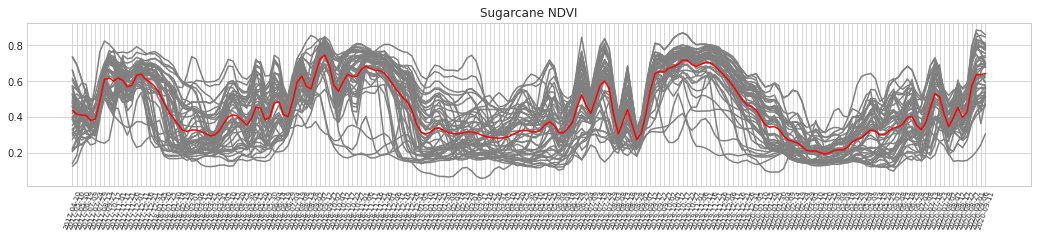

In [40]:
start = 0
stop = 200

fig = plt.figure()
fig.set_size_inches(18, 3)
ax = plt.axes()
for idx in samp_idx:
    ax.plot(week_year_array[start:stop], data_array[idx,0,start:stop], color='grey');

ax.plot(week_year_array[start:stop], np.mean(data_array[samp_idx,0,:],axis=0)[start:stop], color='red');

plt.xticks(rotation=70, size=7)    
plt.title('Sugarcane NDVI')
plt.show()

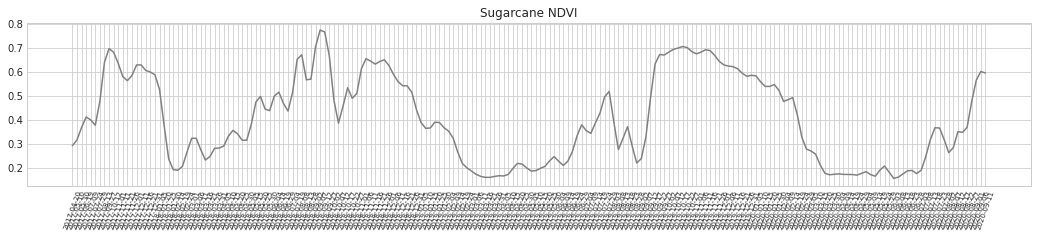

In [41]:
start = 0
stop = 200

fig = plt.figure()
fig.set_size_inches(18, 3)
ax = plt.axes()
for idx in [113]:
    ax.plot(week_year_array[start:stop], data_array[idx,0,start:stop], color='grey');

plt.xticks(rotation=70, size=7)    
plt.title('Sugarcane NDVI')
plt.show()

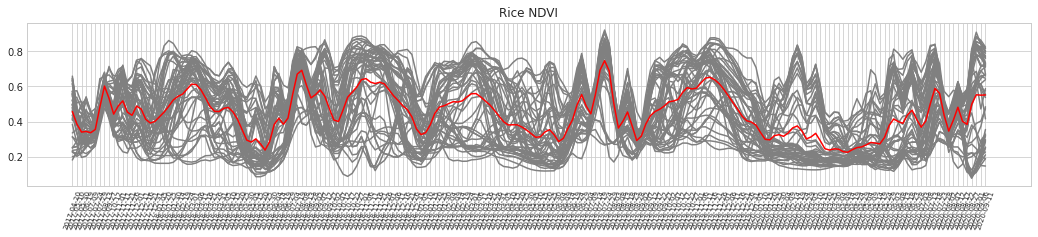

In [42]:
#rice NDVI
start = 0
stop = 200
fig = plt.figure()
fig.set_size_inches(18, 3)
ax = plt.axes()
for idx in samp_idx:
    #ax.plot(week_year_array[130:180], data_array[idx+n_sample,0,130:180], color='grey');
    ax.plot(week_year_array[start:stop], data_array[idx+n_sample,0,start:stop], color='grey');

ax.plot(week_year_array[start:stop], np.mean(data_array[samp_idx+n_sample,0,:],axis=0)[start:stop], color='red');

plt.xticks(rotation=70, size=7) 

plt.title('Rice NDVI')
plt.show()

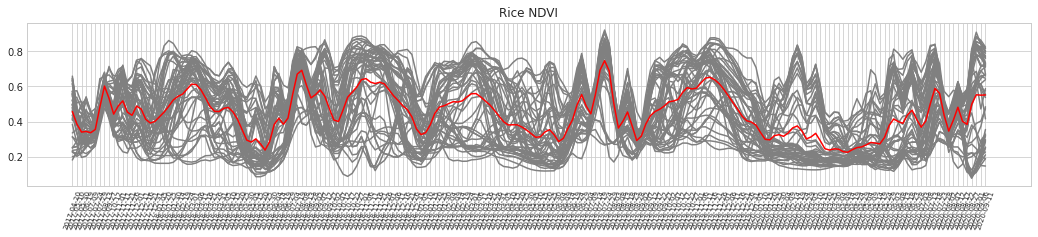

In [43]:

#rice NDVI
fig = plt.figure()
fig.set_size_inches(18, 3)
ax = plt.axes()
for idx in samp_idx:
    #ax.plot(week_year_array[130:180], data_array[idx+n_sample,0,130:180], color='grey');
    ax.plot(week_year_array[start:stop], data_array[idx+n_sample,0,start:stop], color='grey');

ax.plot(week_year_array[start:stop], np.mean(data_array[samp_idx+n_sample,0,:],axis=0)[start:stop], color='red');

plt.xticks(rotation=70, size=7) 

plt.title('Rice NDVI')
plt.show()

In [44]:
week_year_array.shape

(275,)

In [32]:
da

,Array,Chunk
Bytes,89.31 GiB,31.98 MiB
Shape,"(216, 9960, 5572)","(1, 2047, 2048)"
Count,57593 Tasks,9720 Chunks
Type,float64,numpy.ndarray


## 6. Re-shape and export numpy array

In [ ]:
#Save to NPY format
np.savez("for_display.npz", x=data_array, y=labels, location=all_location, weeks = week_year_array)